In [1]:
import dctkit as dt_
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDP as flat
from matplotlib import cm
import pygmo as pg
import math

In [2]:
config()

# Load data

In [3]:
# SPACE PARAMS
L = 5
L_norm = 1
# spatial resolution
dx = 0.05
dx_norm = dx/L
#  Number of spatial grid points
nx = int(L / dx)
nx_norm = int(L_norm/ dx_norm)

# vector containing spatial points
x = np.linspace(0, L, nx)
x_norm = np.linspace(0, L_norm, nx_norm)

# initial velocity
u_0 = 2 * np.exp(-2 * (x - 0.5 * L)**2)
umax = np.max(u_0)

In [4]:
# TIME PARAMS
T = 2
T_norm = T*umax/L
# temporal resolution
dt = 0.01
dt_norm = dt*umax/L
# number of temporal grid points
nt = int(T / dt)
nt_norm = int(T_norm / dt_norm)

# vector containing time points
t = np.linspace(0, T, nt)  
t_norm = np.linspace(0, T_norm, nt_norm)

#Viscosity
nu = 0.06
nu_norm = nu/(L*umax)

In [5]:
def main_run_FDM(u,x, dt, dx, nu, max_time_iter):
    for t in range(max_time_iter):
        u[1:-1, t+1] = u[1:-1, t] + dt * (nu * (u[2:, t] - 2 * u[1:-1, t] + u[:-2, t]) / dx**2 
                   - 0.25 * (u[2:, t]**2 - u[:-2, t]**2) / dx)
        #diffusion = epsilon * (u[2:, t] - 2 * u[1:-1, t] + u[:-2, t]) / dx**2
        #flux = (u[2:, t]**2 - u[:-2, t]**2) /(4*dx)
        #u[1:-1, t+1] = 1/2*(u[2:, t] + u[:-2, t]) + dt * (diffusion - flux)
        #print(np.linalg.norm(u[:,t+1]))
    return u

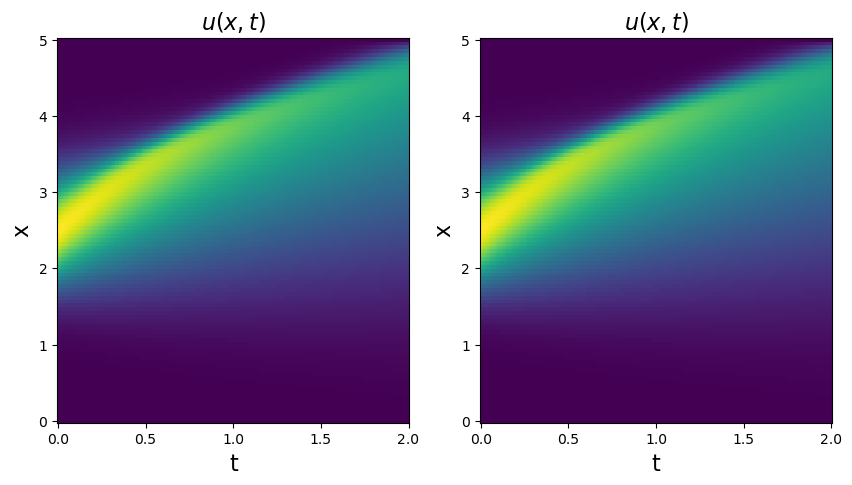

In [6]:
# Array containing velocity
u = np.zeros([nx, nt]) 
u_norm = np.zeros([nx_norm, nt_norm]) 

# Initial condition
u[:, 0] = u_0
# Boundary condition at x=0
u[0, :] = 0
# Boundary condition at x=xmax
u[-1, :] = 0 

u = main_run_FDM(u, x,dt, dx, nu, nt-1)

# Initial condition
u_norm[:, 0] = u_0/umax
# Boundary condition at x=0
u_norm[0, :] = 0
# Boundary condition at x=xmax
u_norm[-1, :] = 0 
u_norm = main_run_FDM(u_norm, x_norm,dt_norm, dx_norm, nu_norm, nt_norm-1)

# rescale and plot
u_rescaled = u_norm*umax


fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, x, u)
ax[1].pcolormesh(t,x,u_rescaled)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$u(x, t)$', fontsize=16)
plt.show()

# Solving

In [7]:
# define simplicial complex
tet_node_tags = np.zeros((len(x)-1,2), dtype = dt_.int_dtype)
tet_node_tags[:,0] = np.arange(len(x)-1)
tet_node_tags[:,1] = np.arange(1, len(x))
node_coords = np.zeros((len(x), 2), dtype = dt_.float_dtype)
node_coords[:,0] = x
S = SimplicialComplex(tet_node_tags, node_coords, is_well_centered = True)
S.get_hodge_star()
S.get_flat_PDP_weights()

In [8]:
# define solver
def main_run(u, S, nu, max_time_iter, flux_formulation = False):
    for t in range(max_time_iter):
        u_coch = C.CochainP0(S, u[:,t])
        dissipation = C.scalar_mul(C.star(C.coboundary(u_coch)), nu)
        if flux_formulation:
            flux = C.scalar_mul(C.square(u_coch), -1/2)
            mean_flux = flat(flux)
            total_flux = C.add(C.star(mean_flux), dissipation)
            balance = C.star(C.coboundary(total_flux))
            #u[1:-1, t+1] = 1/2*(u[2:, t] + u[:-2, t]) - dt_*balance.coeffs[1:-1]
            u[1:-1, t+1] = u[1:-1, t] + dt*balance.coeffs[1:-1]
        else:
            u_mean = flat(u_coch)
            u_x = C.star(C.coboundary(C.star(u_mean)))
            uu_x = C.cochain_mul(u_coch, u_x)
            diss_balance = C.star(C.coboundary(dissipation))
            balance = C.sub(diss_balance, uu_x)
            u[1:-1,t+1] = u[1:-1,t] + dt*balance.coeffs[1:-1]
    return u

In [9]:
# define initial and boundary conditions
u_0 = np.zeros((len(x), len(t)), dtype = dt_.float_dtype)
u_0[:,0] =2 * np.exp(-2 * (x - 0.5 * L)**2) 
u_0[0, :] = 0  
u_0[-1, :] = 0

In [10]:
# solve
u_sol = main_run(u_0.copy(), S, nu, nt - 1, True)

# Plots

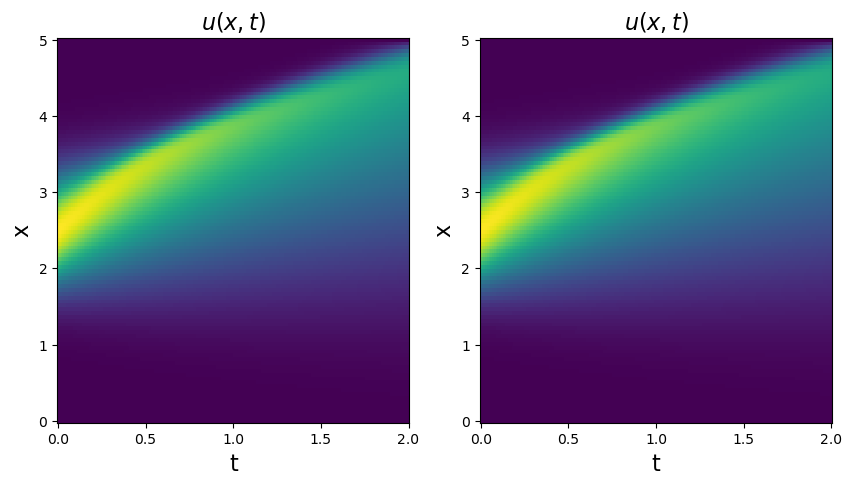

In [11]:
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, x, u)
ax[1].pcolormesh(t,x,u_sol)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$u(x, t)$', fontsize=16)
plt.show()

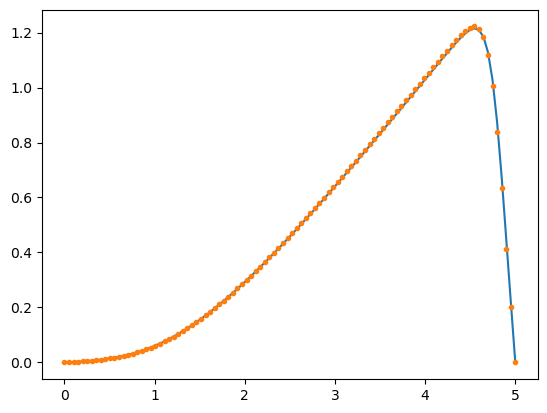

In [12]:
plt.plot(x, u[:,-1])
plt.plot(x, u_sol[:,-1], marker = ".", linewidth = 0.01)
plt.show()

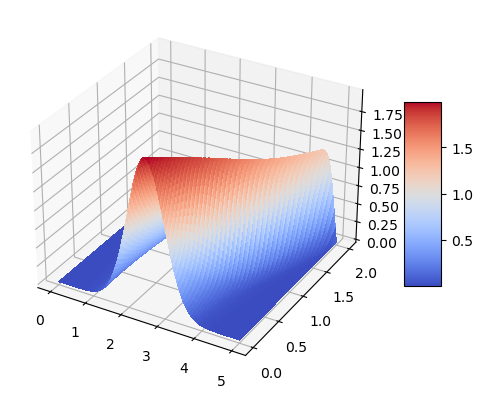

In [13]:
# 3d plot u
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x_mesh, t_mesh = np.meshgrid(x, t)
surf = ax.plot_surface(x_mesh, t_mesh, u.T, cmap=cm.coolwarm, rcount=nx, ccount=nt,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

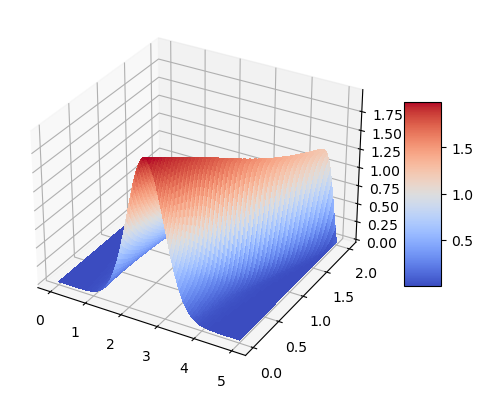

In [14]:
# 3d plot u_sol
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x_mesh, t_mesh = np.meshgrid(x, t)
surf = ax.plot_surface(x_mesh, t_mesh, u_sol.T, cmap=cm.coolwarm, rcount=nx, ccount=nt,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Test with explicit solution

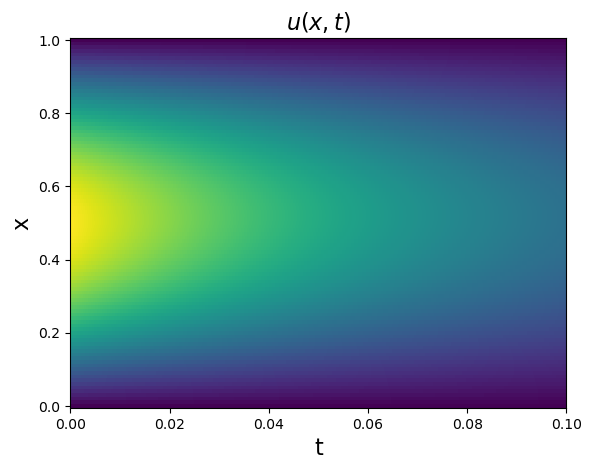

In [15]:
dx = 0.01
x = np.linspace(0, 1, int(1/dx) + 1)
dt = 0.00001
nt = int(0.1/dt) + 1
t = np.linspace(0, 0.1, nt)
nu = 1


u_0 = np.zeros((len(x), len(t)), dtype = dt_.float_dtype)
u_0[:,0] = np.sin(np.pi*x)
u_0[0,:] = 0
u_0[-1,:] = 0


u = main_run_FDM(u_0.copy(), x,dt, dx, nu, nt-1)

plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.show()

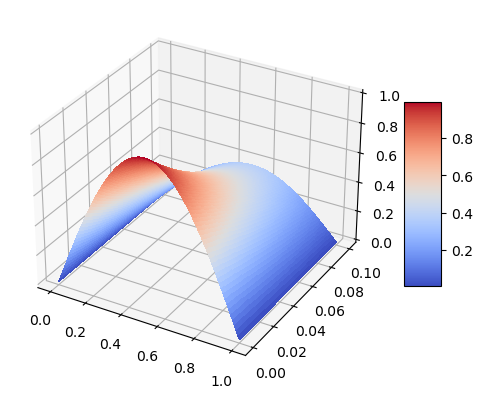

In [16]:
# 3d plot u
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x_mesh, t_mesh = np.meshgrid(x, t)
surf = ax.plot_surface(x_mesh, t_mesh, u.T, cmap=cm.coolwarm, rcount=nx, ccount=nt,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [17]:
# regenerate mesh
tet_node_tags = np.zeros((len(x)-1,2), dtype = dt_.int_dtype)
tet_node_tags[:,0] = np.arange(len(x)-1)
tet_node_tags[:,1] = np.arange(1, len(x))
node_coords = np.zeros((len(x), 2), dtype = dt_.float_dtype)
node_coords[:,0] = x
S = SimplicialComplex(tet_node_tags, node_coords, is_well_centered = True)
S.get_hodge_star()
S.get_flat_PDP_weights()

In [18]:
u_explicit = main_run(u_0.copy(), S, nu, nt - 1, True)

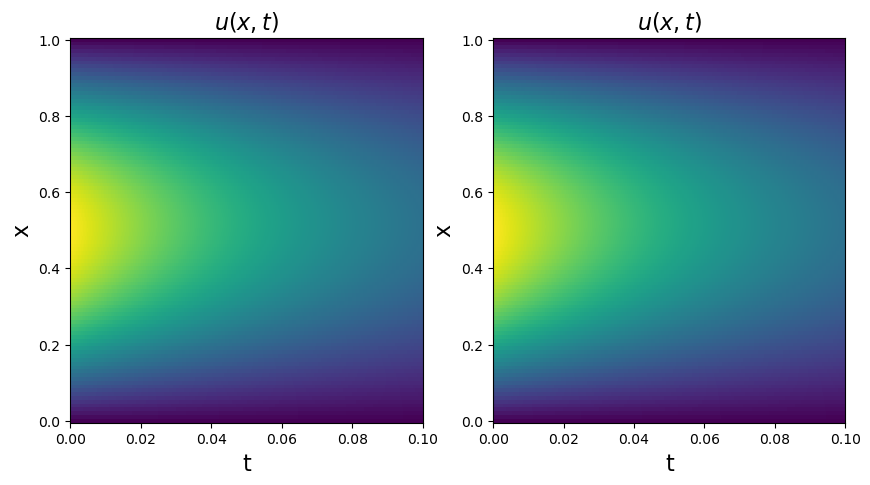

In [19]:
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, x, u)
ax[1].pcolormesh(t,x,u_explicit)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$u(x, t)$', fontsize=16)
plt.show()

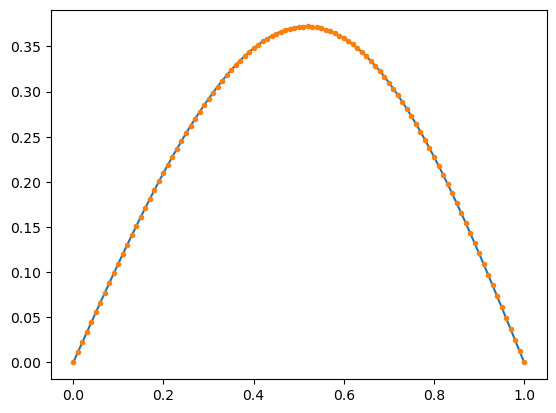

In [20]:
plt.plot(x, u[:,-1])
plt.plot(x, u_explicit[:,-1], marker = ".", linewidth = 0.01)
plt.show()

# Viscosity autotune

In [21]:
# Problem PARAMS
L = 5
dx = 0.05
nx = int(L / dx)
x = np.linspace(0, L, nx)
T = 2
dt = 0.01
nt = int(T / dt)
t = np.linspace(0, T, nt)  
u_0 = 2 * np.exp(-2 * (x - 0.5 * L)**2)
nu = 0.06

In [22]:
# define simplicial complex
tet_node_tags = np.zeros((len(x)-1,2), dtype = dt_.int_dtype)
tet_node_tags[:,0] = np.arange(len(x)-1)
tet_node_tags[:,1] = np.arange(1, len(x))
node_coords = np.zeros((len(x), 2), dtype = dt_.float_dtype)
node_coords[:,0] = x
S = SimplicialComplex(tet_node_tags, node_coords, is_well_centered = True)
S.get_hodge_star()
S.get_flat_PDP_weights()

In [23]:
class Problem:
    def __init__(self, x, L, t, dt, nx, nt, u_0):
        self.x = x
        self.L = L
        self.t = t
        self.dt = dt
        self.nx = nx
        self.nt = nt
        self.u_0 = u_0

    
    def burgers_step(self,u_t, nu):
        u_coch = C.CochainP0(S, u_t)
        dissipation = C.scalar_mul(C.star(C.coboundary(u_coch)), nu)
        flux = C.scalar_mul(C.square(u_coch), -1/2)
        mean_flux = flat(flux)
        total_flux = C.add(C.star(mean_flux), dissipation)
        balance = C.star(C.coboundary(total_flux))
        return balance
    
    def fitness(self,nu):
        total_err = 0
        u = np.zeros((self.nx, self.nt), dtype = dt_.float_dtype)
        u[:,0] = self.u_0
        u[0, :] = 0  
        u[-1, :] = 0
        for t in range(self.nt-1):
            balance = self.burgers_step(u[:,t], nu)
            u[1:-1, t+1] = u[1:-1, t] + self.dt*balance.coeffs[1:-1]
            if np.isnan(u[:, t+1]).any() or (np.abs(u[:, t+1]) > 1e5).any():
                total_err = np.nan
                break

        if math.isnan(total_err):
            total_err = 1
        else:
            total_err = np.mean(np.linalg.norm(u - u_sol, axis=0)**2)
        return [total_err]

    def get_bounds(self):
        return ([0.000001], [1])

In [28]:
prb = Problem(x=x, L=L, t=t, dt=dt, nx=nx, nt=nt, u_0=u_0)
algo = pg.algorithm(pg.sea(gen=10))
algo.set_verbosity(2)
prob = pg.problem(prb)
pop = pg.population(prob, size=100)
pop = algo.evolve(pop)

In [29]:
print(f"The best fitness is {pop.champion_f}")
print(f"The best viscosity is {pop.champion_x}")

The best fitness is [0.0007463]
The best viscosity is [0.05841678]
